# Local approximation of a bivariate quadratic expression using linear regression

Given two features, extract y (the label), perform linear regression.
Coming from the single feature model, 2 features is adding some complexity not only on the maths, but also on the display through charts.

### Learning goals:
- Analiticaly solve the linear regression and implement it with simple "raw" Python
- Use powers of the features to increase the model capacity
- Use some off the shelve methods of Numpy
- Switch to iterative methods with gradient descent (GD) and stochastic gradient descent (SGD)
- SGD with powers of the features
- Add L2 regularizer to the SGD with powers to improve convergence and fit

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import normalize as skNormalize
import pandas

In 2D, it would require many points to uniformly cover the x plan

It is then prefer to draw x points from a 2D uniform distribution

Ploting y as function of $x_0, x_1$ is then more challenging as $x_0$ and $x_1$ are not continuous monotonic vectors

$f(x) = (x_0−0.2)^4 + (x_0−0.1)^3 + 0.1 x_1^2 + 0.35 = x_0^4 + 0.2 x_0^3 − 0.06 x_0^2 − 0.002 x_0 + 0.1 x_1^2 + 0.3506$

In [2]:
# f(x) as a bivariate polynom
fPoly = np.array([[-0.002, 0], [-0.06, 0.1], [0.2, 0], [1, 0]])
# Generator
def generateBatch(N):
    #
    xMin = np.array([0, -0.5])
    xMax = np.array([0.5, 0.5])
    #
    b = 0.35
    std = 0.01
    #
    x = random.uniform(xMin, xMax, (N, 2))
    yClean = (x[:,0]-0.2)**4 + (x[:,0]-0.1)**3 + 0.1*x[:,1]**2 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

In [3]:
N = 100000
xTrain, yTrain, yTrainClean = generateBatch(N);
print('x', xTrain.shape, ', yClean', yTrainClean.shape, ', y', yTrain.shape);

xTest, yTest, yTestClean = generateBatch(N);

x (100000, 2) , yClean (100000,) , y (100000,)


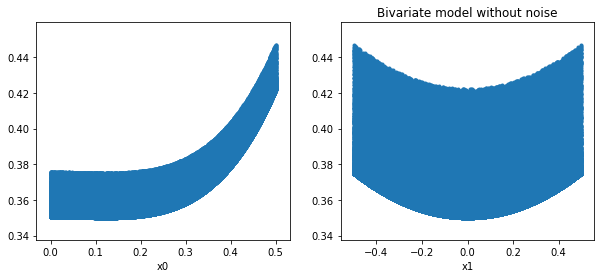

In [4]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTrain[:,0], yTrainClean, marker='.');
plt.xlabel('x0')
plt.subplot(1,2,2)
plt.scatter(xTrain[:,1], yTrainClean, marker='.');
plt.xlabel('x1')
plt.title('Bivariate model without noise');

It looks like a tobogan from the side ($x_0$) and from the front ($x_1$)

## Analiticaly / Closed form

Remove biases

In [5]:
xUnB = xTrain - np.mean(xTrain, axis=0)
yUnB = yTrain - np.mean(yTrain)

See [Univariate regression workbook for more details](LinearRegressionUnivariate.ipynb)

\begin{align}
w_{est} = min_w \lVert x w - y_u \rVert_2^2
\end{align}

\begin{align}
L_2(w) & = \lVert x w - y_u \rVert_2^2 \\
\end{align}

Lookup the minimum through the partial derivate:

$$\frac{\partial{L_2(w)}}{\partial w} = 0 \iff w = (x^T x)^{-1} x^T y_u$$

## Maison

In [6]:
xTxInv = np.linalg.inv(np.matmul(xUnB.T,xUnB))
wEst = np.matmul(xTxInv,np.matmul(xUnB.T, yUnB))
wEst

array([  1.12630050e-01,  -8.44634598e-05])

In [7]:
bEst = np.mean(yTrain - np.matmul(xTrain, wEst))
bEst

0.34393818033022144

### Test model

In [8]:
yEst1 = np.matmul(xTest, wEst) + bEst

Linear regression MSE = 2.589e-04


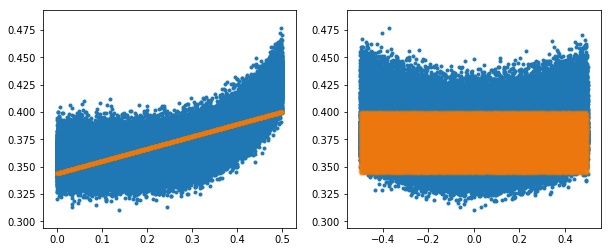

In [9]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTest, marker='.');
plt.scatter(xTest[:,0], yEst1, marker='.', alpha=0.05);
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTest, marker='.');
plt.scatter(xTest[:,1], yEst1, marker='.', alpha=0.05);
# Mean square error 'a la mano'
mse1 = np.dot(yTest-yEst1, yTest-yEst1) / N
print('Linear regression MSE = {:.3e}'.format(mse1));

The tobogan has been approximated by a plan

## Home made with powers
Adding some flexibility to the model using powers of x

In [10]:
xTrain2 = np.concatenate((xTrain, xTrain**2, xTrain**3, xTrain**4), axis=1)
xTrain2.shape

(100000, 8)

In [11]:
x2UnB = xTrain2 - np.mean(xTrain2, axis=0)

In [12]:
x2Tx2Inv = np.linalg.inv(np.matmul(x2UnB.T,x2UnB))
w2 = np.matmul(x2Tx2Inv,np.matmul(x2UnB.T, yUnB))
w2

array([ -4.58130371e-03,  -2.67096338e-04,  -4.51778412e-02,
         1.01159062e-01,   1.60773592e-01,   1.23549392e-03,
         1.03813475e+00,  -4.53447566e-03])

### Test model

In [13]:
xTest2 = np.concatenate((xTest, xTest**2, xTest**3, xTest**4), axis=1)
yEst2 = np.matmul(xTest2, w2) + bEst

Linear regression with powers, MSE = 1.461e-04, MSE to clean test data = 4.599e-05


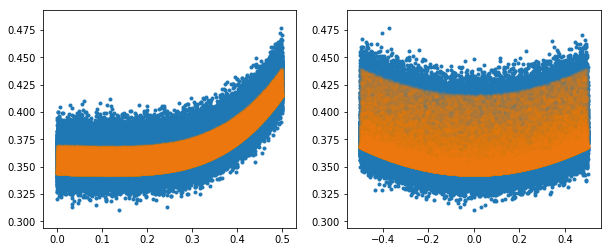

In [14]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTest2[:,0], yTest, marker='.');
plt.scatter(xTest2[:,0], yEst2, marker='.', alpha=0.05);
plt.subplot(1,2,2)
plt.scatter(xTest2[:,1], yTest, marker='.');
plt.scatter(xTest2[:,1], yEst2, marker='.', alpha=0.05);
mse2 = np.dot(yTest-yEst2, yTest-yEst2) / N
mse2Clean = np.dot(yTestClean-yEst2, yTestClean-yEst2) / N
print('Linear regression with powers, MSE = {:.3e}, MSE to clean test data = {:.3e}'.format(mse2, mse2Clean));

The polynomial of y has been well approximated.

The MSE on the noisy sample should not be lower than the MSE of the noise which is $(10^{-2})^2=10^{-4}$

## NumPy least square

In [15]:
fit4, residues, rank, s = np.linalg.lstsq(xUnB, yUnB)
fit4

array([  1.12630050e-01,  -8.44634598e-05])

### Test model

In [16]:
yEst4 = np.matmul( xTest, fit4) + bEst

Numpy least square, MSE = 2.589e-04


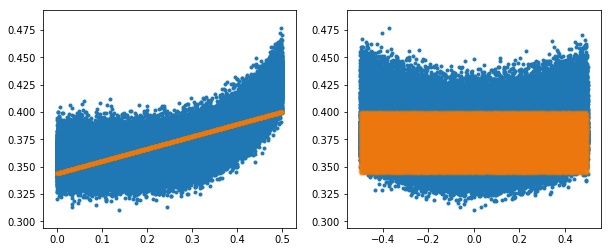

In [17]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTest, marker='.');
plt.scatter(xTest[:,0], yEst4, marker='.', alpha=0.05);
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTest, marker='.');
plt.scatter(xTest[:,1], yEst4, marker='.', alpha=0.05);
mse4 = metrics.mean_squared_error(yTest, yEst4)
print('Numpy least square, MSE = {:.3e}'.format(mse4) );

# Gradient descent

Attempt to find a value of w such that the gradient is null (indication of minima, or saddle point)

Loop on the training data until the gradient is below a threshold

Gradient on $w$ for a linear regression is:
\begin{align}
\nabla_{w} = X^T (X w - y)
\end{align}

In [18]:
# Gradient computation
def calcGradient(x, y, w, debiasData = True):
    if debiasData:
        _x = x - np.mean(x, axis=0)
        _y = y - np.mean(y)
    else:
        _x = x
        _y = y
    gradient = np.matmul(_x.T, np.matmul(_x, w) - _y)
    return gradient

# Plot helper to show target reference value
def plotToRef(label, subNum, subRow, subCol, ref, values):
    nIter = len(values)
    r = range(nIter)
    plt.subplot(subNum, subRow, subCol)
    plt.title(label)
    plt.plot(r, values, r, np.ones((nIter))*ref, alpha=0.5)
    plt.grid();

## Standard gradient descent

Loop on the same train data

In [19]:
w6 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.0001 # Quick
gradient = calcGradient(xUnB, yUnB, w6, False)
gradientNorm = np.sum(gradient**2) # bivariate
print('w start =', w6, ', Gradient norm =', gradientNorm)
w6Learn = [np.concatenate((w6, [gradientNorm]))]
while gradientNorm > threshold:
    w6 = w6 - learningRate * gradient
    gradient = calcGradient(xUnB, yUnB, w6, False)
    gradientNorm = np.sum(gradient**2) # bivariate
    # print('w =', w6, ', Gradient norm =', gradientNorm)
    w6Learn.append(np.concatenate((w6, [gradientNorm])))
print('w end =', w6, ', Gradient norm =', gradientNorm, ', num iteration =', len(w6Learn))
df6 = pandas.DataFrame(w6Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 1821749638.53
w end = [  1.12630502e-01  -8.44620012e-05] , Gradient norm = 8.72400249845e-07 , num iteration = 71


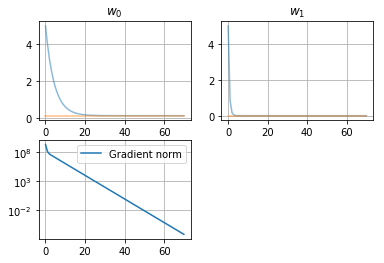

In [20]:
plotToRef('$w_0$', 2,2,1, wEst[0], df6['w0'])
plotToRef('$w_1$', 2,2,2, wEst[1], df6['w1'])
plt.subplot(2,2,3)
plt.semilogy(df6['Gradient norm'])
plt.grid()
plt.legend();

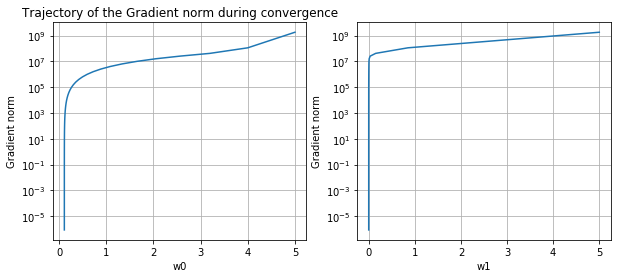

In [21]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogy(df6['w0'], df6['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.title('Trajectory of the Gradient norm during convergence')
plt.subplot(1,2,2)
plt.semilogy(df6['w1'], df6['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

### Test model

In [22]:
yEst6 = np.matmul(xTest, w6) + bEst

Gradient descent MSE = 2.589e-04


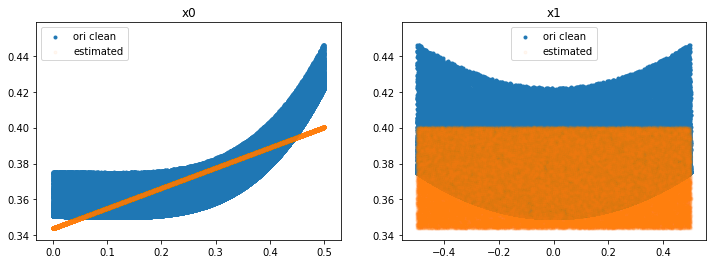

In [23]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst6, marker='.', alpha=0.05)
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst6, marker='.', alpha=0.05)
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse6 = metrics.mean_squared_error(yTest, yEst6)
print('Gradient descent MSE = {:.3e}'.format(mse6));

## Stochastic gradient descent

Loop on new data, smaller batch

In [24]:
Nbatch = 1000
w7 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
gradient = calcGradient(xBatch, yBatch, w7)
gradientNorm = np.sum(gradient**2) 
print('w start =', w7, ', Gradient norm =', gradientNorm)
w7Learn = [np.concatenate((w7, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w7 = w7 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    gradient = calcGradient(xBatch, yBatch, w7)
    gradientNorm = np.sum(gradient**2)
    w7Learn.append(np.concatenate((w7, [gradientNorm])))
    learningRate = learningRate * 0.99
print('w end =', w7, ', Gradient norm =', gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 199119.636194
w end = [  1.12835610e-01   5.69861305e-05] , Gradient norm = 4.22682915213e-08 , num iteration = 15654


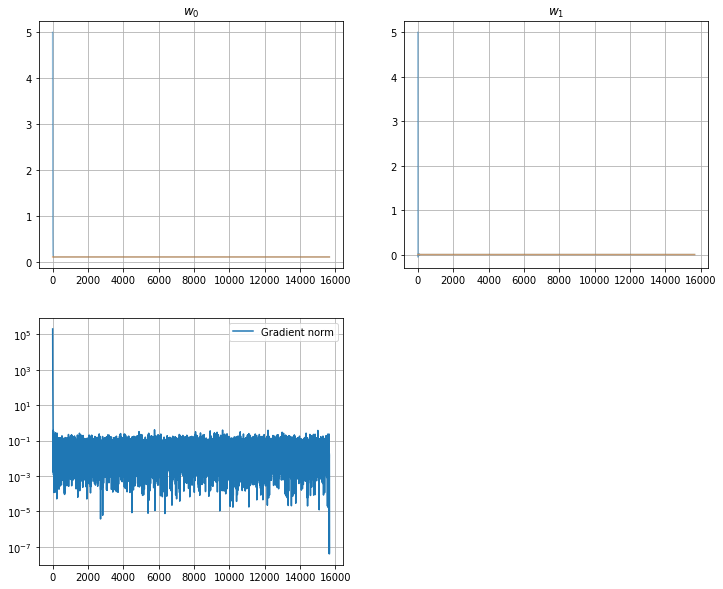

In [25]:
fig = plt.figure(figsize=(12,10))
plotToRef('$w_0$', 2,2,1, wEst[0], df7['w0'])
plotToRef('$w_1$', 2,2,2, wEst[1], df7['w1'])
plt.subplot(2,2,3)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.legend();

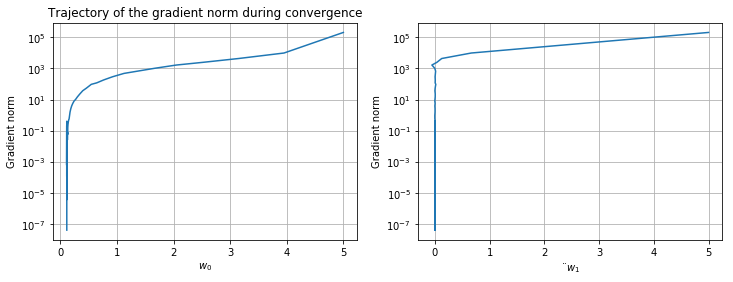

In [26]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogy(df7['w0'], df7['Gradient norm'])
plt.xlabel('$w_0$')
plt.ylabel('Gradient norm')
plt.grid();
plt.title('Trajectory of the gradient norm during convergence')
plt.subplot(1,2,2)
plt.semilogy(df7['w1'], df7['Gradient norm'])
plt.xlabel('¨$w_1$')
plt.ylabel('Gradient norm')
plt.grid();

### Test model

In [27]:
yEst7 = np.matmul(xTest, w7) + bEst

Stochastic gradient descent MSE = 2.589e-04


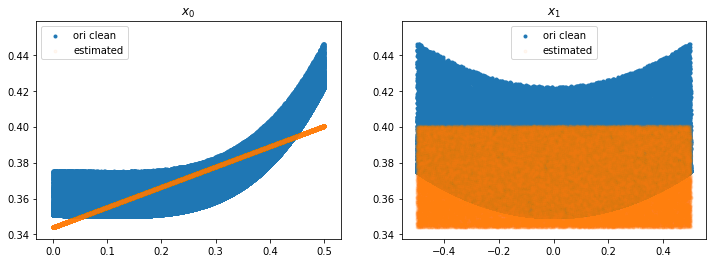

In [28]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst7, marker='.', alpha=0.05)
plt.title('$x_0$')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst7, marker='.', alpha=0.05)
plt.title('$x_1$')
plt.legend(('ori clean', 'estimated'))
mse7 = metrics.mean_squared_error(yTest, yEst7)
print('Stochastic gradient descent MSE = {:.3e}'.format(mse7));

## SGD with powers

Adding powers of x to the stochastic gradient descent

In [29]:
# Batch size
nBatch = 1000
# Initial coefficient (fixed and tuned manually for this trial)
w8 = np.ones(8)* 1.5 
# Gradient descent end threshold (on the gradient)
threshold = 1e-4
# Initial learning rate
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(nBatch)
xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
gradient = calcGradient(xBatch2, yBatch, w8)
gradientNorm = np.sum(gradient**2) 
print('w start =', w8, ', Gradient norm = {:.3e}'.format(gradientNorm))
# Save the 
w8Learn = [np.concatenate((w8, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w8 = w8 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(nBatch)
    xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
    gradient = calcGradient(xBatch2, yBatch, w8)
    gradientNorm = np.sum(gradient**2)
    w8Learn.append(np.concatenate((w8, [gradientNorm])))
    #learningRate = learningRate * 0.9999
print('w end =', w8, ', Gradient norm = {:.3e}'.format(gradientNorm), ', num iteration =', len(w8Learn))
df8 = pandas.DataFrame(w8Learn, columns = ('w0_1', 'w1_1', 'w0_2', 'w1_2', 'w0_3', 'w1_3', 'w0_4', 'w1_4', 'Gradient norm'))

w start = [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5] , Gradient norm = 2.547e+04
w end = [  1.64864034e-02   7.47544097e-04  -1.69279991e-01   5.11777968e-02
   4.07537744e-01  -8.91471606e-05   8.91661960e-01   2.29219582e-01] , Gradient norm = 5.092e-05 , num iteration = 7421


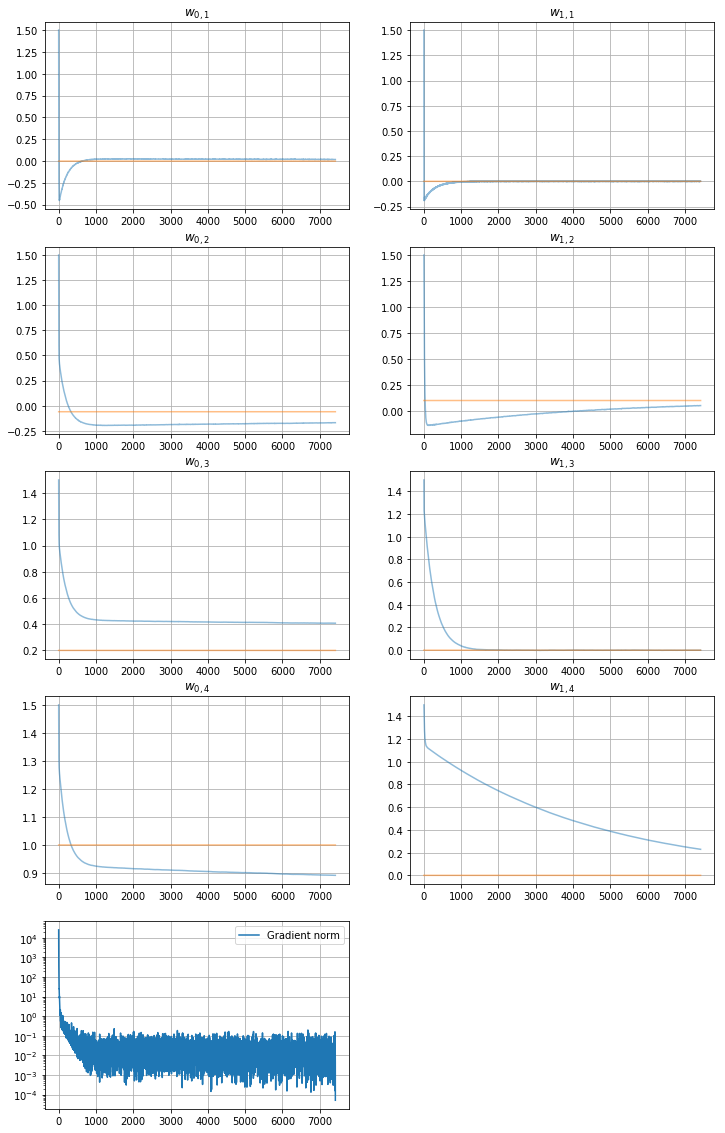

In [30]:
fig = plt.figure(figsize=(12,20))
plotToRef('$w_{0,1}$', 5,2,1, fPoly[0,0], df8['w0_1'])
plotToRef('$w_{1,1}$', 5,2,2, fPoly[0,1], df8['w1_1'])
plotToRef('$w_{0,2}$', 5,2,3, fPoly[1,0], df8['w0_2'])
plotToRef('$w_{1,2}$', 5,2,4, fPoly[1,1], df8['w1_2'])
plotToRef('$w_{0,3}$', 5,2,5, fPoly[2,0], df8['w0_3'])
plotToRef('$w_{1,3}$', 5,2,6, fPoly[2,1], df8['w1_3'])
plotToRef('$w_{0,4}$', 5,2,7, fPoly[3,0], df8['w0_4'])
plotToRef('$w_{1,4}$', 5,2,8, fPoly[3,1], df8['w1_4'])
plt.subplot(5,2,9)
plt.semilogy(df8['Gradient norm'])
plt.grid()
plt.legend();

Convergence is not correct on $w_{1}$ that should only feature a small coefficient on the 2nd order term and no coefficient on the fourth order $w_{1,4}$

### Test model

In [31]:
yEst8 = np.matmul(xTest2, w8) + bEst

Stochastic gradient descent MSE = 1.535e-04


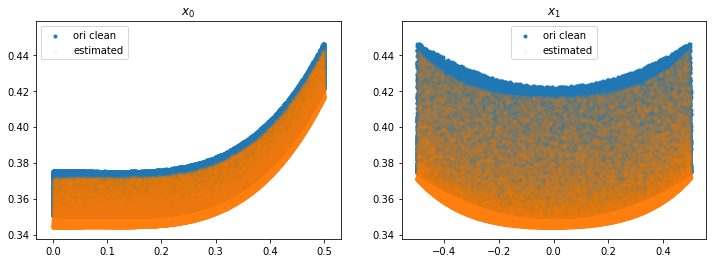

In [32]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst8, marker='.', alpha=0.05)
plt.title('$x_0$')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst8, marker='.', alpha=0.05)
plt.title('$x_1$')
plt.legend(('ori clean', 'estimated'))
mse8 = metrics.mean_squared_error(yTest, yEst8)
print('Stochastic gradient descent MSE = {:.3e}'.format(mse8));

### Conclusion on SGD with powers

The fitting of the 4th and 3rd degree powers takes more time, leading to a initial  w shape on the right hand graph ($x_1$).

The MSE is improved, but the optimizer is harder to tune

## SGD with powers and regularizer

Let's add a regularizer to the SGD with powers, using the Euclidian norm (L2)

Gradient on $w$ for a linear regression with L2 regularizer is:
\begin{align}
\nabla_{w} = X^T (X w - y) + \lambda w
\end{align}

In [33]:
# Calculate gradient with regularizer and normalization
def calcGradientRegularizeL2(x, y, w, lam):
    _x = x - np.mean(x, axis=0) # skNormalize(x, axis=0)
    _y = y - np.mean(y)
    gradient = np.matmul(_x.T, np.matmul(_x, w) - _y) + lam * w
    return gradient

In [34]:
# Batch size
nBatch = 1000
# Initial coefficient (fixed and tuned manually for this trial)
w9 = np.ones(8)* 1.5 
# Gradient descent end threshold (on the gradient)
threshold = 1e-4
# Initial learning rate
learningRate = 0.01
# Regularizer param
lambdaReg = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(nBatch)
xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
gradient = calcGradientRegularizeL2(xBatch2, yBatch, w9, lambdaReg)
gradientNorm = np.sum(gradient**2) 
print('w start =', w9, ', Gradient norm = {:.3e}'.format(gradientNorm))
# Save the 
w9Learn = [np.concatenate((w9, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w9 = w9 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(nBatch)
    xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
    gradient = calcGradientRegularizeL2(xBatch2, yBatch, w9, lambdaReg)
    gradientNorm = np.sum(gradient**2)
    w9Learn.append(np.concatenate((w9, [gradientNorm])))
    # learningRate = learningRate * 0.9999
print('w end =', w9, ', Gradient norm = {:.3e}'.format(gradientNorm), ', num iteration =', len(w9Learn))
df9 = pandas.DataFrame(w9Learn, columns = ('w0_1', 'w1_1', 'w0_2', 'w1_2', 'w0_3', 'w1_3', 'w0_4', 'w1_4', 'Gradient norm'))

w start = [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5] , Gradient norm = 2.880e+04
w end = [ -2.73831100e-02  -4.02097582e-04   1.63209984e-02   7.13525408e-02
   3.47327421e-01   1.37408529e-04   5.54803696e-01   1.30160675e-01] , Gradient norm = 7.515e-05 , num iteration = 7024


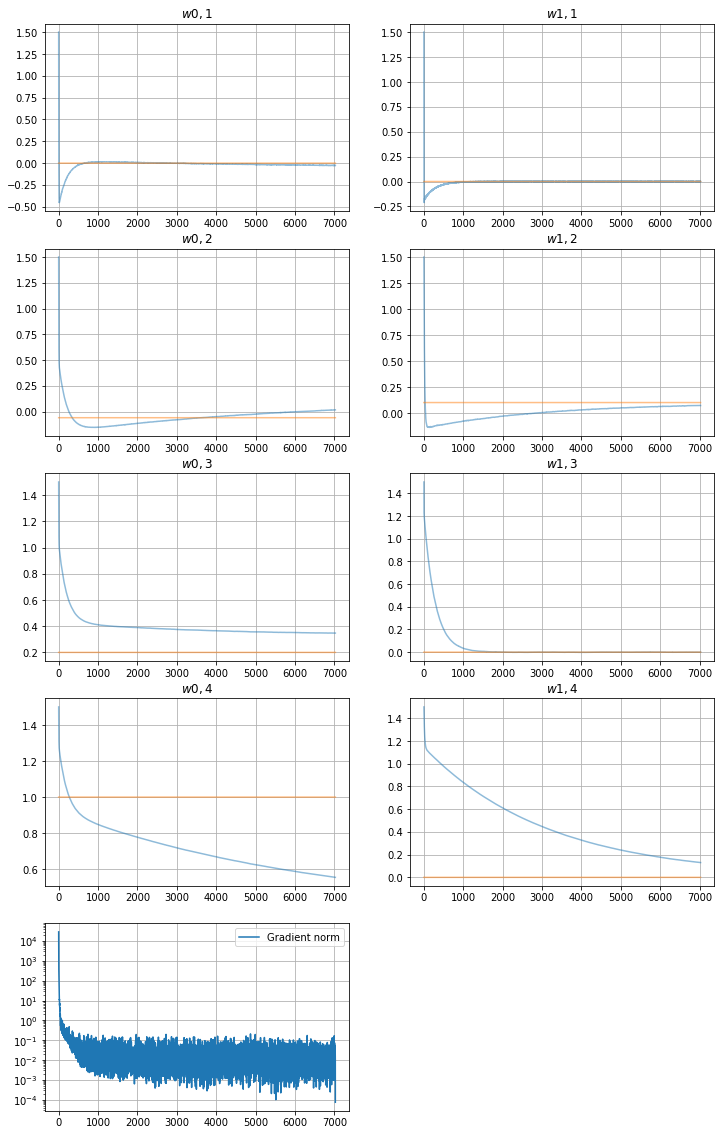

In [35]:
fig = plt.figure(figsize=(12,20))
plotToRef('$w0,1$', 5,2,1, fPoly[0,0], df9['w0_1'])
plotToRef('$w1,1$', 5,2,2, fPoly[0,1], df9['w1_1'])
plotToRef('$w0,2$', 5,2,3, fPoly[1,0], df9['w0_2'])
plotToRef('$w1,2$', 5,2,4, fPoly[1,1], df9['w1_2'])
plotToRef('$w0,3$', 5,2,5, fPoly[2,0], df9['w0_3'])
plotToRef('$w1,3$', 5,2,6, fPoly[2,1], df9['w1_3'])
plotToRef('$w0,4$', 5,2,7, fPoly[3,0], df9['w0_4'])
plotToRef('$w1,4$', 5,2,8, fPoly[3,1], df9['w1_4'])
plt.subplot(5,2,9)
plt.semilogy(df9['Gradient norm'])
plt.grid()
plt.legend();

### Test model

In [36]:
yEst9 = np.matmul(xTest2, w9) + bEst

Stochastic gradient descent with L2 regularizer, MSE = 1.711e-04


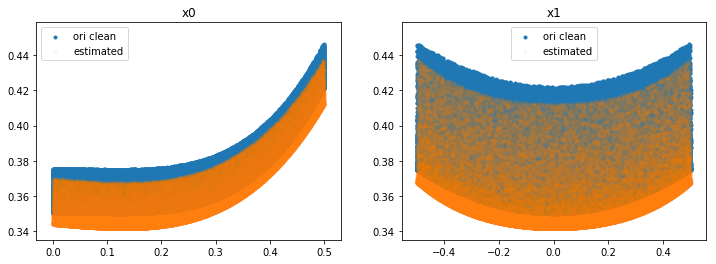

In [37]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst9, marker='.', alpha=0.05)
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst9, marker='.', alpha=0.05)
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse9 = metrics.mean_squared_error(yTest, yEst9)
print('Stochastic gradient descent with L2 regularizer, MSE = {:.3e}'.format(mse9));

### Conclusion on SGD with regularizer

The regularizer has a larger effect on 3rd and 4th degree terms, leading to a fitting that mostly use 1st and 2nd degree (parabolic)

Also, the bias (intercept) seems a little too low, leading to higher MSE.

# Where to go from here ?

__Other two feature linear implementation__ [using Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionBivariate-Keras.ipynb))

__Compare with the two feature binary classification using logistic regression__ [using "raw" Python or libraries](../classification/ClassificationContinuous2Features.html) ([Notebook](../classification/ClassificationContinuous2Features.ipynb]))